# Understanding the Factors that Influence the Growth of Mobile Games

## By Sathvik Ravi

## Introduction

Since the explosion of smartphone technology in the late 2000's, mobile games have become increasingly popular as a way for consumers to pass the time. Almost overnight, simplistic yet tantalizing games such as Flappy Bird and Piano Keys become popular, which motivates the analysis that I would like to conduct. Using a dataset that contains numbers for installations, five-star ratings, categorical data, and growth rate, I would like to predict how quickly an app will grow (in terms of downloads and ratings) based on present data. This type of analysis can especially be useful to new app developers, who may have data from focus groups or case studies, but do not have historical data to use to project their growth. It can also be useful to large app developers who already have historical data by allowing them to ascertain how current statistics such as rank, ratings, and price are impacting their growth. By analyzing factors, such as rank, price, average app rating, etc., predicting the growth rate can be helpful to developers by helping them to project the next big app.

### Gathering Data

Fortunately, I was able to find a publicly available dataset on Kaggle (link: https://www.kaggle.com/dhruvildave/top-play-store-games) where I was able to download a csv file containing information on the top 100 games in the Google Play Store across a variety of different gaming genres (i.e. Action, Adventure, etc.).

All libraries used in this project are imported here:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import scipy

In [2]:
df = pd.read_csv('android-games.csv')
df.head()

,rank,title,total ratings,installs,average rating,growth (30 days),growth (60 days),price,category,5 star ratings,4 star ratings,3 star ratings,2 star ratings,1 star ratings,paid
0,1,Garena Free Fire - The Cobra,80678661,500.0 M,4.33,2.9,7.9,0.0,GAME ACTION,61935712,4478738,2795172,1814999,9654037,False
1,2,PUBG MOBILE: Graffiti Prank,35971961,100.0 M,4.24,2.0,3.1,0.0,GAME ACTION,26670566,2109631,1352610,893674,4945478,False
2,3,Mobile Legends: Bang Bang,25836869,100.0 M,4.08,1.6,3.3,0.0,GAME ACTION,17850942,1796761,1066095,725429,4397640,False
3,4,Brawl Stars,17181659,100.0 M,4.27,4.1,6.6,0.0,GAME ACTION,12493668,1474319,741410,383478,2088781,False
4,5,Sniper 3D: Fun Free Online FPS Shooting Game,14237554,100.0 M,4.33,0.8,1.8,0.0,GAME ACTION,9657878,2124544,1034025,375159,1045945,False


In the above data, growth is a metric formed by including increase in total number of installs and total number of ratings and finding the average percentage growth. It is calculated in comparison to the day that the metric is updated in the last 30 days and last 60 days.

### Cleaning the Data

Currently, the "installs" column is recognized as an object type. But the value we need is an integer. There are also multiple rows within the dataset that repeat game titles, so we will have to make sure each row of our dataset contains a unique title. We also need to clarify exactly what "growth" is (the increase in the number of installations as a percentage of the initial number of installations at the start of the time period for the data collection). 

In [3]:
# Re-formatting the installs column

for index, row in df.iterrows():
    array = row['installs'].split(' ')
    
    # 'M' in the dataset indicates million and 'k' indicates thousand
    if array[1] == 'M':
        number = float(array[0])
        number *= 1000000.0
    else:
        number = float(array[0])
        number *= 1000.0
        
    df.at[index, 'installs'] = number
    
df['installs'] = df['installs'].astype('int')

Within the data, if we enter the command `df['title'].unique()` we see that not all of the titles in the dataset are unique, so it will benefit us to remove the duplicate rows.

In [4]:
# Drop the rows that have duplicate title names. 

df = df.drop_duplicates(subset=['title'])

For this dataset, the growth is calculated as the average percentage increase in total number of installs and total number of ratings over a certain time period (in our case, 30 and 60 days) up until the date of data collection. Growth is a custom metric provided by the Play Store.

In [5]:
# Renaming the growth columns to clarify what we're measuring

df = df.rename(columns={'growth (30 days)': 'Percent growth in 30 days', 'growth (60 days)': 'Percent growth in 60 days'})

In terms of calculating the growth, it can be helpful to standardize measures such as the number of 5 star ratings as a percentage so that our processing is faster since the numbers are smaller and so we can compare growth across different games and genres.

In [6]:
# Converting number of star ratings to percentage

for index, row in df.iterrows():
    df.at[index, '% 5 star'] = (row['5 star ratings'] / row['total ratings']) * 100.0
    df.at[index, '% 4 star'] = (row['4 star ratings'] / row['total ratings']) * 100.0
    df.at[index, '% 3 star'] = (row['3 star ratings'] / row['total ratings']) * 100.0
    df.at[index, '% 2 star'] = (row['2 star ratings'] / row['total ratings']) * 100.0
    df.at[index, '% 1 star'] = (row['1 star ratings'] / row['total ratings']) * 100.0

We can also shorten the category names so that they are more visible when we present graphs, charts, and visualizations later in the tutorial.

In [7]:
for index, row in df.iterrows():
    df.at[index, 'category'] = row['category'][5:]

## Exploratory Data Analysis

In the process of combing through the dataset to try and find patterns, it can be helpful to create visualizations of different relationships in the data that we may hypothesize. In our case, we will be comparing growth rate over 60 days with metrics such as rank, installs, average rating, category, and percentage of 5 star reviews among others.

### Part 1: Rank vs. Percent Growth in 60 Days

Overall, we expect that there should be a negative correlation that as the rank of the app increases (as in the app is lower-ranked) that the app has a smaller growth rate.

In [8]:
# Initializing our linear model

lm = linear_model.LinearRegression()

Linear regression model given by: y = 0.03334299254367651x + 2.3190707237831516


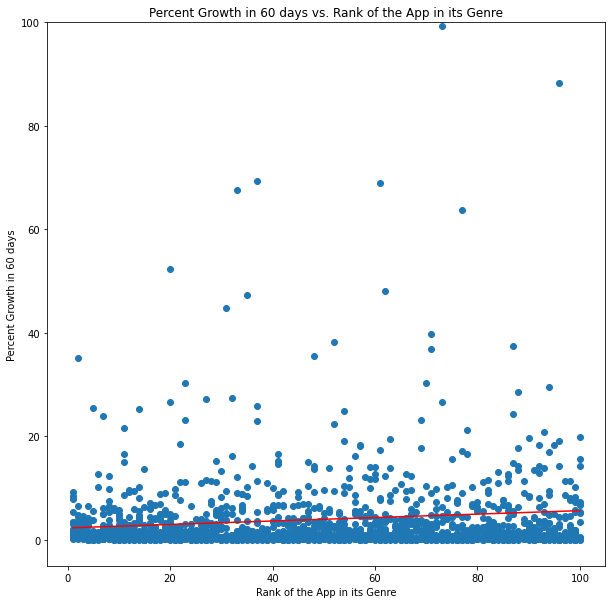

In [9]:
plt.subplots(figsize=(10,10))

y = 'Percent Growth in 60 days'
x = 'Rank of the App in its Genre'
plt.scatter(x=df['rank'].values, y=df['Percent growth in 60 days'].values)
plt.xlabel('Rank of the App in its Genre')
plt.ylabel('Percent Growth in 60 days')
plt.title(y + ' vs. ' + x)
plt.ylim([-5,100])

# Initializing our independent variable
ind = df['rank'].values.reshape(-1, 1)

lm.fit(ind, df['Percent growth in 60 days'].values)
plt.plot(ind, lm.predict(ind), color='red')

print('Linear regression model given by: y = ' + str(lm.coef_[0]) + 'x + ' + str(lm.intercept_) )

### Part 2: Total Ratings vs. Percent Growth in 60 Days

We hypothesize that applications that have a higher number of ratings on the Play Store will in turn be growing at a much higher rate than those that have fewer ratings.

Linear regression model given by: y = -1.2544333103062895e-07x + 4.140457119968493


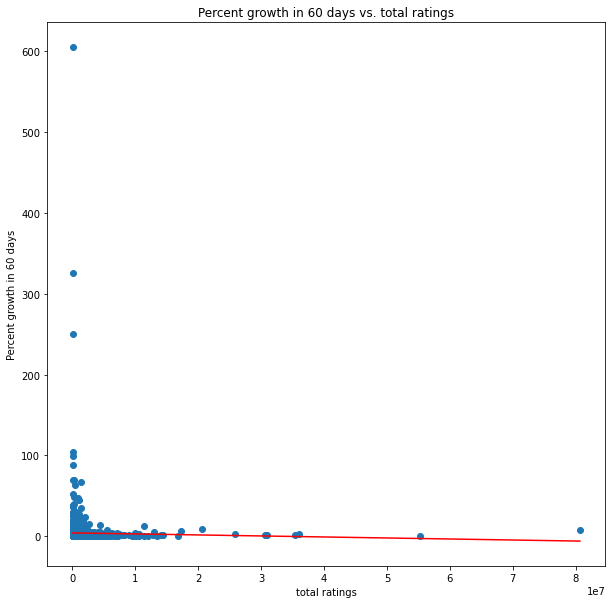

In [10]:
plt.subplots(figsize=(10,10))

y = 'Percent growth in 60 days'
x = 'total ratings'
plt.scatter(x=df[x].values, y=df[y].values)
plt.xlabel(x)
plt.ylabel(y)
plt.title(y + ' vs. ' + x)

ind = df[x].values.reshape(-1, 1)
lm.fit(ind, df[y].values)
plt.plot(ind, lm.predict(ind), color='red')

print('Linear regression model given by: y = ' + str(lm.coef_[0]) + 'x + ' + str(lm.intercept_) )

From the visual, we can see that the majority of the values are clustered between 0 and 10000000 ratings. However, there does not seem to be a strong correlation between the total number of ratings and the growth rate.

### Part 3: Average Rating vs. Percent Growth in 60 Days 

We hypothesize that there will be a positive linear correlation between the growth rate and the average rating. 

Linear regression model given by: y = 2.8717860948910205x + -8.368934412151857


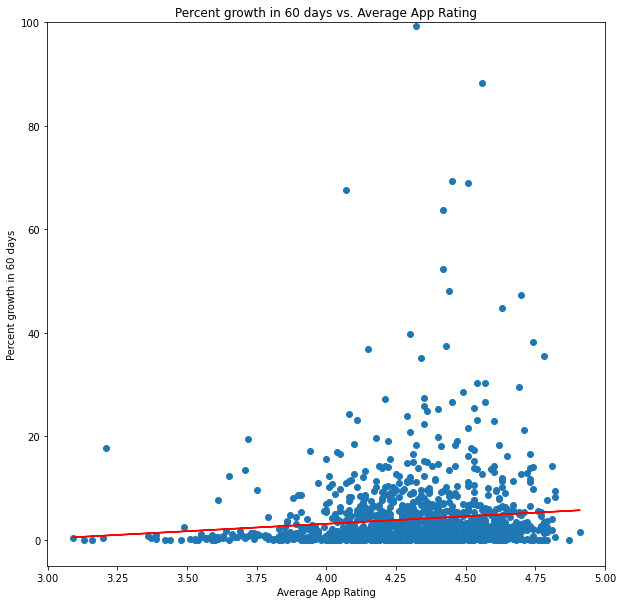

In [11]:
plt.subplots(figsize=(10,10))
x = 'Average App Rating'
y = 'Percent growth in 60 days'
plt.scatter(x=df['average rating'].values, y=df['Percent growth in 60 days'].values)
plt.xlabel(x)
plt.ylabel(y)
plt.title(y + ' vs. ' + x)
plt.ylim([-5, 100])

ind = df['average rating'].values.reshape(-1, 1)
lm.fit(ind, df['Percent growth in 60 days'].values)
plt.plot(ind, lm.predict(ind), color='red')

print('Linear regression model given by: y = ' + str(lm.coef_[0]) + 'x + ' + str(lm.intercept_) )

### Part 4: Installs vs. Percent Growth in 60 Days 

We hypothesize that as the number of installs (downloads) increases, that the growth rate should also increase.

Linear regression model given by: y = -6.533389226115977e-09x + 4.1882573837566115


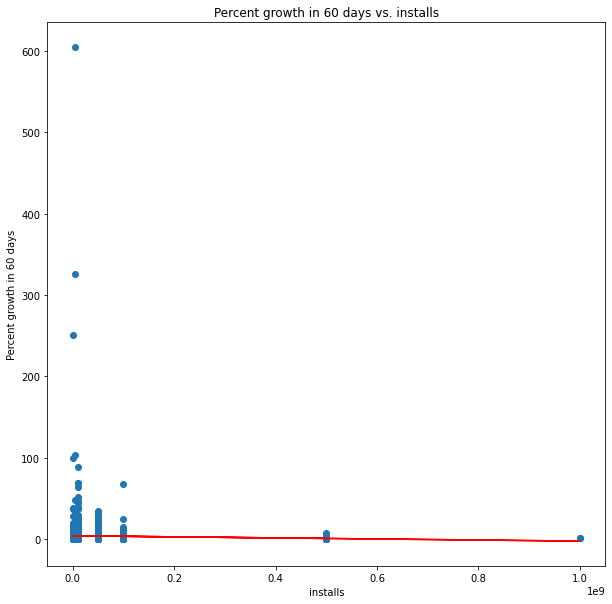

In [12]:
plt.subplots(figsize=(10,10))

y = 'Percent growth in 60 days'
x = 'installs'
plt.scatter(x=df[x].values, y=df[y].values)
plt.xlabel(x)
plt.ylabel(y)
plt.title(y + ' vs. ' + x)

ind = df[x].values.reshape(-1, 1)
lm.fit(ind, df[y].values)
plt.plot(ind, lm.predict(ind), color='red')

print('Linear regression model given by: y = ' + str(lm.coef_[0]) + 'x + ' + str(lm.intercept_) )

Contrary to what we expected, the growth rate decreased as the number of installs increased. This can likely be attributed to the fact that as the number of downloads increase, there is a carrying capacity which is defined by the finite number of Android phone users. Therefore, apps with more installations require a higher number of downloads to achieve an equivalent percentage, and since the number of downloads is limited by the number of Android users, this relationship has a negative correlation. It is also important to note that since the Play Store only records an approximate value for the number of installs rather than the exact value, it can be hard to derive a significant relationship using this value.

### Part 5: Category vs. Growth Rate

<AxesSubplot:xlabel='category', ylabel='Percent growth in 60 days'>

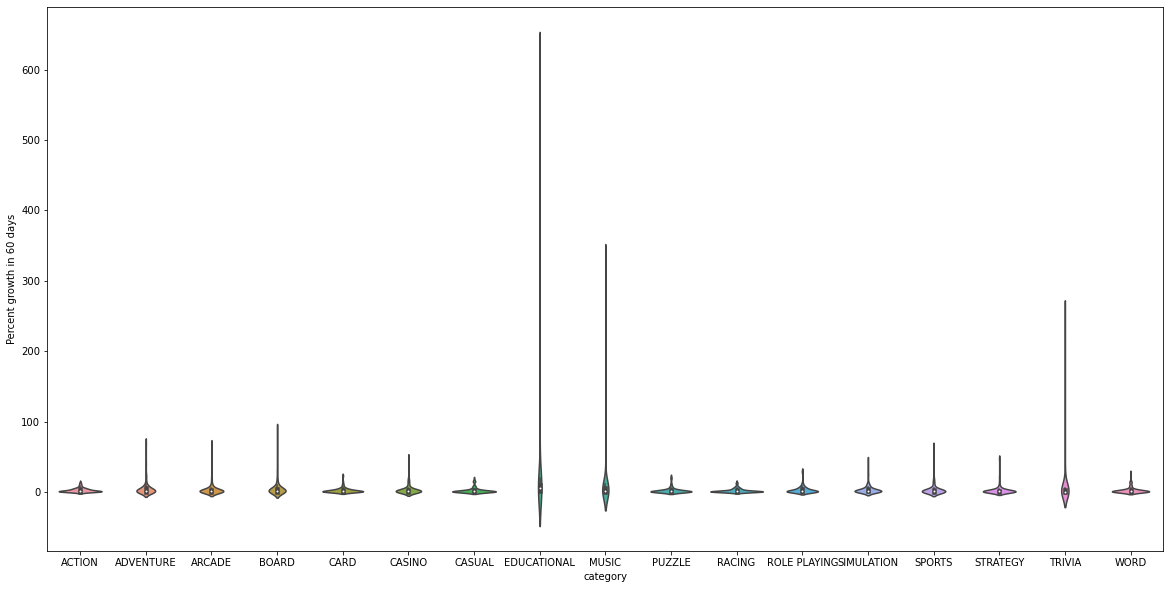

In [13]:
plt.subplots(figsize=(20,10))
sns.violinplot(x="category", y="Percent growth in 60 days", data=df)

From the above violin plot, it 'EDUCATIONAL', 'MUSIC', and 'TRIVIA' have a significantly larger growth distribution than the other categories. In particular, the 'EDUCATIONAL' category has a higher median growth rate than the other categories and a much larger interquartile range than the other categories. For this reason, the 'EDUCATIONAL' category may be considered an interaction term since it significantly varies with the growth rate. 

In [14]:
# Adding an 'EDUCATIONAL' column to our dataset

for index, row in df.iterrows():
    if row['category'] == 'EDUCATIONAL':
        df.at[index, 'is_education'] = 1
    else:
        df.at[index, 'is_education'] = 0

### Part 6: Percentage of 5 star ratings vs. Growth Rate

We hypothesize that as the percentage of 5 star ratings increases, that the growth rate should also increase.

Linear regression model given by: y = 0.17770686333789404x + -8.459757604577788


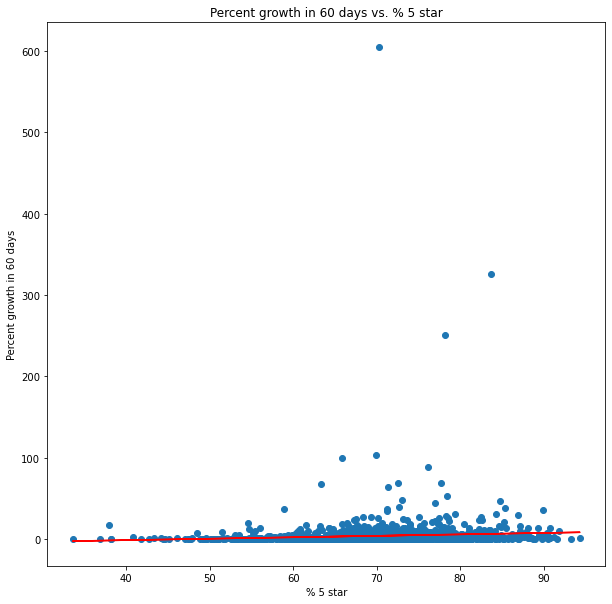

In [15]:
plt.subplots(figsize=(10,10))

y = 'Percent growth in 60 days'
x = '% 5 star'
plt.scatter(x=df[x].values, y=df[y].values)
plt.xlabel(x)
plt.ylabel(y)
plt.title(y + ' vs. ' + x)

ind = df[x].values.reshape(-1, 1)
lm.fit(ind, df[y].values)
plt.plot(ind, lm.predict(ind), color='red')

print('Linear regression model given by: y = ' + str(lm.coef_[0]) + 'x + ' + str(lm.intercept_) )

As we predicted, there is a significant linear correlation between the percentage of 5 star reviews for an app and the growth rate.

### Observing Relationships Between Different Columns and Multicollinearity

Next, we can look at the amount of correlation between features in order to see how related they are to one another. Specifically, we are most interested which features have the highest influence on growth rate over 60 days. We also want to avoid considering independent variables that are highly correlated with each other, also called multicollinearity, since this results in estimates for regression coefficients being unreliable and the tests of significance for these regression coefficients can be misleading.

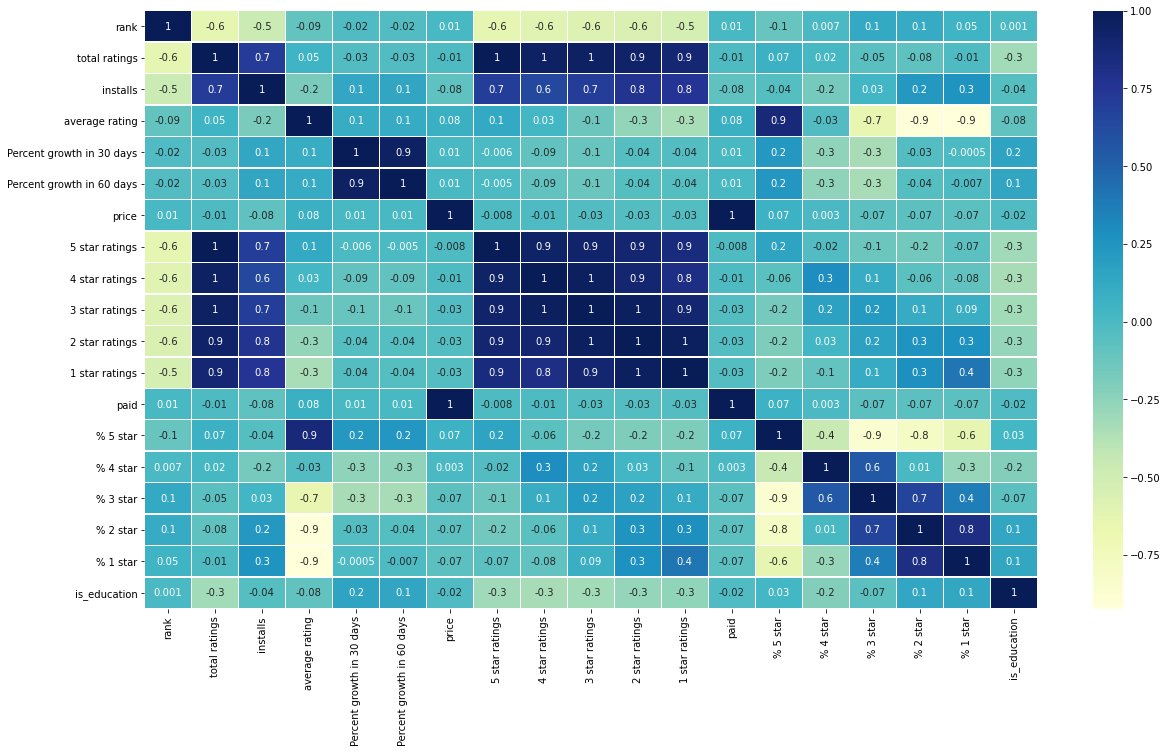

In [16]:
plt.subplots(figsize = (20,11))

# We want to use the spearman correlation coefficient because we don't want to make any assumptions about our data
g = sns.heatmap(df.corr('spearman'), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

From the above correlation matrix, we see that rank and total ratings do not have much correlation with growth rate over 60 days, which was evidenced by the figures we created in Parts 1 and 2. Installs and average rating both had a high degree of correlation with growth rate, but average rating also had high degree of association with percentage of 5 star reviews, which potentially shows multicollinearity. The columns that had the highest degree of correlation with growth rate were the percentage of 5 star reviews, percentage of 4 star reviews, and percentage of 3 star reviews, however these columns also exhibit high degrees of associativity. Additionally, the is_education column had a high degree of associativity with our grwoth rate, which was also evidenced by the figure in Part 5. 

In the end, the best variables for predicting growth rate are the '% 5 star reviews', '% 4 star reviews', and the 'is_education' columns. The '% 5 star reviews' has a high degree of associativity with our target variable but is also highly correlated with 'average ratings', and thus, encapsulates that relationship as well. Similarly, the '% 4 star reviews' and 'is_education' columns also have a high degree of associativity with our target variable. We do not include the '% 3 star reviews' column even though it has high associativity with our target column because it is highly correlated with the '% 5 star reviews column', so we risk multicollinearity.

## Hypothesis Testing and Machine Learning

Based on the correlation matrix, we hypothesize that there is a relationship between our growth rate and the other features. Let's see if we can use models to fit and predict the growth rate. 

### Linear Regression

In [17]:
y_var = df[["Percent growth in 60 days"]]
x_var = df[['% 5 star','is_education', '% 4 star']]

# Scale the data so we can fit it faster and so certain features do not affect predictions more than other features
scaler = MinMaxScaler(feature_range=(0, 1))
x_var = scaler.fit_transform(x_var)
y_var = scaler.fit_transform(y_var)

LinearModel = sm.OLS(y_var, x_var, missing='drop').fit()
LinearModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.063
Model:                            OLS   Adj. R-squared (uncentered):              0.062
Method:                 Least Squares   F-statistic:                              37.70
Date:                Mon, 17 May 2021   Prob (F-statistic):                    1.42e-23
Time:                        18:50:56   Log-Likelihood:                          3416.3
No. Observations:                1672   AIC:                                     -6827.
Df Residuals:                    1669   BIC:                                     -6810.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0138      0.002      5.912      0.000       0.009       0.018
x2             0.0158      0.003      4.846      0.000       0.009       0.022
x3            -0.0083      0.004     -2.088      0.037      -0.016      -0.001
==============================================================================
Omnibus:                     3935.568   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27522775.411
Skew:                          22.576   Prob(JB):                         0.00
Kurtosis:                     629.917   Cond. No.                         4.07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see here, our R-squared value is extremely low, which means that the independent variables we selected ('% 5 star' and 'is_education') explain only about 6% of the variation in the dependent variable ('Percent growth in 60 days'). However, the P-value for the columns is just 0. This means that the probability of obtaining test results equally extreme as the results we just observed is minimal. Generally, the significance level for determining whether two variables have a linear correlation is 0.05. Therefore, both of our variables are shown to be statistically significant.

(-0.1, 0.2)

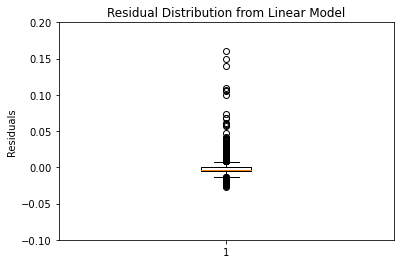

In [18]:
plt.boxplot(x=LinearModel.resid)
plt.ylabel('Residuals')
plt.title('Residual Distribution from Linear Model')
plt.ylim([-0.1, 0.2])

The above boxplot shows the distribution of residuals. The residual points are clearly centered around 0, however our data contains a number of outliers in terms of positive residual values. We can use a probability plot to see if the residual distribution is normal.

((array([-3.34294222, -3.08843744, -2.94706749, ...,  2.94706749,
          3.08843744,  3.34294222]),
  array([-0.0267718 , -0.02555989, -0.02478594, ...,  0.40460283,
          0.52799246,  0.97732664])),
 (0.012361658620016005, 3.864331051754358e-05, 0.3934637950843113))

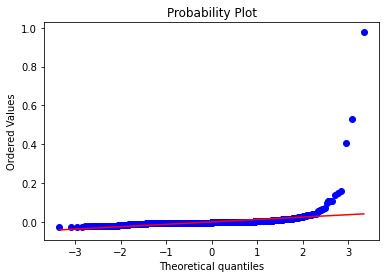

In [19]:
scipy.stats.probplot(LinearModel.resid, dist="norm", plot=plt)

The above visual represents a probability plot. The data are plotted against a theoretical normal distribution in such a way that the points should form an approximate straight line. Departures from this straight line indicate departures from normality. As we can see, the residuals have a curvilinear distribution with a heavy tail. This means that our dataset contains more extreme values than would be typically found in a normal distribution. Therefore, our residuals are not normally distributed, which violates the assumptions of our linear regression.

## Communication of Insights

After analyzing the top 100 ranked games across various genres from the Google Play Store, we have come away with several findings. After creating several linear regression equations and scatter plots, we found that the most significant correlations with growth rate over 60 days existed with the percentage of 5 and 4 star reviews and whether the app was educational or not. However, in incorporating these values into a linear regression, we found that our independent variables were weakly correlated with our target variable (as evidenced by the low R-squared value) but that there may have been a statistically significant relationship between with our selected features and our target value as shown by the low P-value. Unfortunately, since the residual values from our model were not normally distributed, this violates an important assumption of our linear regression model, and thus, we cannot conclude that there is a significant correlation between our feature variables and our target variable.

The next steps to investigate factors that impact the growth rate of an app would be to create a larger dataset that encompasses more values across the various genres so that our distribution is not overweighted by extreme values. This can be performed by web-scraping data from the Google Play Store, however, the Play Store does not make growth data for applications explicitly available online. Once this data can be collected for a wide variety of applications, not just the top 100 applications, we can begin to make conclusions about what impacts growth. 

## Resources

Kaggle Dataset: https://www.kaggle.com/dhruvildave/top-play-store-games

More Information about Probability Plots: https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm#:~:text=The%20probability%20plot%20(Chambers%20et,form%20approximately%20a%20straight%20line.